In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from seaborn import scatterplot
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit


In [2]:
df = pd.read_csv('dataset_vehicles.csv')
# Shuffle the dataset
df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

In [3]:
df.shape

(18938, 19)

In [4]:
df.dtypes #as we can see from this output, there is a lot of mixed datatypes in the columns

Title             object
Sub_title         object
Price             object
Brand             object
Model             object
Edition           object
Year               int64
Condition         object
Transmission      object
Body              object
Fuel              object
Capacity          object
Mileage           object
Location          object
Description       object
Post_URL          object
Seller_name       object
Seller_type       object
published_date    object
dtype: object

In [5]:
df.Price.unique() #checking to see if there is any other currencies involved before stripping out the Rs

array(['Rs 5,600,000', 'Rs 9,800,000', 'Rs 2,175,000', ...,
       'Rs 2,730,000', 'Rs 3,135,000', 'Rs 4,435,000'], dtype=object)

### Time to clean this durty data

- firstly lets change the price column to integer values


Things to consider:
- check for duplicates
- there may be a need to fill in missing values  with mean etc.
- check non numeric feature rows for illegal values
- for supervised learning, target values need to be present and sensible


#### lets see if there are any duplicates
There may be cases in this dataset where there are multiple occurences of the same car ie. A car being advertised multiple times by a seller in order to get more publicity. To takle this problem, we must establish what is considered duplicate entry in this dataset.

For this, lets consider the key attributes of the car for sale: Make, model, price, location, seller, mileage, body, capacity, description, condition, transmission, year, edition and fuel.

If these attributes are the same across two or more entries, then it is safe to say that it is a duplicate entry.

In [6]:
dup_feat = ['Title','Brand','Price','Mileage','Body','Seller_name','Location','Model','Capacity','Description','Condition','Transmission','Year','Edition','Fuel']
dup = df[dup_feat]
dup.duplicated().sum()

532

In [7]:
#from this we can see that there are 532 duplicated rows, lets remove these
df = df.drop_duplicates(subset=dup_feat, keep='first')

#### Now lets convert some columns to numeric
in order to do this we must first strip out string characters such as ',' 'RS', 'km' etc.

In [8]:
df['Price']=df['Price'].str.replace('Rs|,| ','')
df['Mileage']=df['Mileage'].str.replace('km|,| ','')
df['Capacity']=df['Capacity'].str.replace('cc|,| ','')

Now lets convert them to numeric

In [9]:

df['Price'] = df['Price'].astype('int64')
df['Mileage'] = df['Mileage'].astype('int64')
df['Capacity'] = df['Capacity'].astype('int64')

In [10]:
#only keeping the features I deemed necessary for predicting price
features = ["Brand","Model","Year","Condition","Fuel","Capacity","Mileage"]
numeric_features = ["Mileage","Year","Capacity"]
nominal_features = ["Brand","Model","Condition","Fuel"]

In the above feature lists I only retained features I deemed necessary for my predictions. In the case of nominal features I discarded ones such as 'Description' as this would lead to thousands of one hot encoded values since each description should be unique.

In [11]:
for f in nominal_features:
    print(f,df[f].unique()) #inspect nominal features to see if there are any anomalies

Brand ['Honda' 'Kia' 'Suzuki' 'Micro' 'Toyota' 'Nissan' 'Audi' 'Mitsubishi'
 'Mercedes Benz' 'Peugeot' 'Zotye' 'Daihatsu' 'Hyundai' 'Perodua' 'BMW'
 'Jaguar' 'Land Rover' 'Maruti Suzuki' 'Mazda' 'Lexus' 'Tata' 'MG' 'DFSK'
 'Proton' 'Mini' 'Chery' 'Ford' 'Citroen' 'Isuzu' 'Volkswagen' 'Daewoo'
 'Datsun' 'Volvo' 'Mahindra' 'Chrysler' 'Austin' 'Porsche' 'Other brand'
 'Morris' 'Chevrolet' 'Maruti' 'Renault' 'Ssang Yong' 'Fiat' 'Subaru'
 'Geely' 'Alfa Romeo' 'Hummer' 'Rover' 'Tesla' 'Moto Guzzi' 'Jeep'
 'Aston Martin' 'Opel' 'Skoda' 'Smart' 'Vauxhall']
Model ['Fit Shuttle' 'Sorento' 'Estilo' 'MX 7' 'Harrier' 'Maruti' 'March' 'Axio'
 'Aqua' 'Wagon R Stingray' 'Hilux' 'Premio' 'Sunny' 'Soluna' 'A6' 'Vitz'
 'Lancer' 'Alto' 'Prius' 'Hustler' 'E300' 'Land Cruiser Sahara' '407'
 'C200' 'Corolla' 'Starlet' 'Extreme' 'Terios' 'Mira' 'Celerio' 'Stellar'
 'Land Cruiser Prado' 'Avanza' 'A3' 'Baleno' 'E200' 'Grace' 'Leaf' 'Panda'
 'Viva Elite' 'X1' 'XF' 'Swift' 'Vezel' 'Range Rover Sport' 'Boon' 'A1'


In [12]:
df.dtypes

Title             object
Sub_title         object
Price              int64
Brand             object
Model             object
Edition           object
Year               int64
Condition         object
Transmission      object
Body              object
Fuel              object
Capacity           int64
Mileage            int64
Location          object
Description       object
Post_URL          object
Seller_name       object
Seller_type       object
published_date    object
dtype: object

from this exploration of some of the nominal data features, I can see that there are some incorrect values, for example there are some very small engine capacities ('1cc','4cc' and '3cc') and some very large engine capacities('10000cc'). Having checked against some online sources, these values appear to be mistakes as the smallest engine size of a production car is 624cc with the largest being 5980cc.

Values outside this range will need to be changed to a mean value of engine capacity.

In [13]:
# Only include examples where engine capicity is in the correct range
df = (df[(df["Capacity"] >= 624) & (df["Capacity"] < 5980)]).copy()

In [14]:
# Check for NaNs in the case of numeric features
for feature in numeric_features:
    print(feature, df[feature].isnull().values.any())

Mileage False
Year False
Capacity False


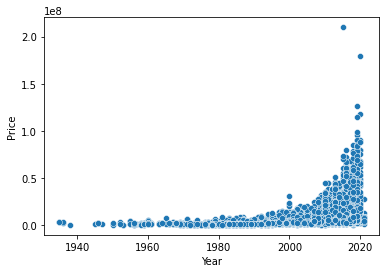

In [15]:
plot = scatterplot(x="Year",y="Price",data=df) 

Viewing this graph it is clear that there are some outliers. From some research online I found that the most expensive car sold in sri lanka (a Rolls Royce Wraith) went for 15,80,00,000 RS
Thus, with this knowledge I will remove any cars with prices above this value. I also found no examples of cars which dipped below 50,000 RS but to be safe (in the case of absolute bangers) I will set a lower boundary of 10,000 RS. Anything outside of this range will be excluded

In [16]:
# Only include examples whose price falls in the established range
df = (df[(df["Price"] < 158000000) & (df["Price"] > 10000)]).copy()

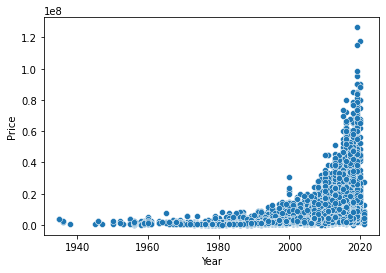

In [17]:
plot = scatterplot(x="Year",y="Price",data=df) 

There still appears to be some outliers regarding year (<1940) , lets inspect these two example to see if they truely are old cars

In [18]:
df.nsmallest(3, ['Year']) 

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
14164,Austin X Series 1935 for sale,"Posted on 08 Apr 11:22 am, Moratuwa, Colombo",3500000,Austin,Other Model,X Series,1935,Used,Manual,Hatchback,Petrol,700,150000,"Moratuwa, Colombo","Austin X series, Manufactured in the year 1935...",https://ikman.lk/en/ad/austin-x-series-1935-fo...,Sell Fast | Tryst Studio & Communication,Premium-Member,2021-04-08 11:22:00
18553,Austin X Series 1935 for sale,"Posted on 08 Apr 10:32 am, Moratuwa, Colombo",3500000,Austin,Other Model,X Series,1935,Used,Manual,Hatchback,Petrol,700,150000,"Moratuwa, Colombo","Austin X series manufactured in 1935 , in mint...",https://ikman.lk/en/ad/austin-x-series-1935-fo...,Sell Fast | Tryst Studio & Communication,Premium-Member,2021-04-08 10:32:00
6179,Austin 7 1936 for sale,"Posted on 24 Mar 12:32 pm, Malabe, Colombo",1600000,Austin,7,NaN,1936,Used,Manual,Hatchback,Petrol,1000,100000,"Malabe, Colombo",Austin - 1936 / Registerd in 1936 / Petrol / O...,https://ikman.lk/en/ad/austin-7-1936-for-sale-...,Avon Lanka Holdings,Premium-Member,2021-03-24 12:32:00


These seem to be genuine old cars so we will leave them in, The bottom two appear to be duplicates but since the descriptions are slightly different, we cannot rule them out as being seperate cars

In [19]:
df.nlargest(3,['Year'])

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
466,DFSK Glory 580 2021 for sale,"Posted on 22 Jun 3:23 am, Colombo 3, Colombo",6895000,DFSK,Glory,580,2021,New,Tiptronic,NaN,Petrol,1500,0,"Colombo 3, Colombo",07 SeaterSunroof10 inch Touch Screen Audio Sys...,https://ikman.lk/en/ad/dfsk-glory-580-2021-for...,LB Finance Plc,Premium-Member,2021-06-22 03:23:00
1130,DFSK Glory I Auto 2021 for sale,"Posted on 05 Jun 2:35 pm, Colombo 3, Colombo",8495000,DFSK,Glory,I Auto,2021,New,Automatic,NaN,Petrol,1498,0,"Colombo 3, Colombo","* Engine, body, interior in excellent conditio...",https://ikman.lk/en/ad/dfsk-glory-i-auto-2021-...,LB Finance Plc,Premium-Member,2021-06-05 14:35:00
1710,DFSK Glory 580 2021 for sale,"Posted on 01 Apr 10:39 am, Kohuwala, Colombo",6650000,DFSK,Glory,580,2021,Used,Tiptronic,SUV / 4x4,Petrol,1500,920,"Kohuwala, Colombo",Fully Loaded Luxry EditionFull Size 7 SeaterBl...,https://ikman.lk/en/ad/dfsk-glory-580-2021-for...,Sagara,Premium-Member,2021-04-01 10:39:00


seems all good, no new cars with extremely high mileage 

#### Lets inspect all the columns to see if we can pick up anymore outliers/errors in the data

In [20]:
df.describe(include='all')

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
count,18171,18171,1.817100e+04,18171,18171,13378,18171.00000,18171,18171,16349,18171,18171.000000,18171.000000,18171,18171,18171,18171,18171,18171
unique,10214,16638,NaN,57,512,6261,NaN,3,4,7,6,NaN,NaN,198,16848,17645,6010,1,14755
top,Suzuki Alto 2015 for sale,"Posted on 09 Mar 2:29 pm, Colombo 3, Colombo",NaN,Toyota,Alto,G Grade,NaN,Used,Automatic,Hatchback,Petrol,NaN,NaN,"Kohuwala, Colombo",* Leasing can be arranged with your requiremen...,https://ikman.lk/en/ad/land-rover-defender-201...,LB Finance PLC,Premium-Member,2021-03-03 11:21:00
freq,179,62,NaN,5624,927,167,NaN,17255,11042,6375,13299,NaN,NaN,1316,148,3,508,18171,66
mean,NaN,NaN,6.477052e+06,NaN,NaN,NaN,2007.82362,NaN,NaN,NaN,NaN,1518.705630,95957.813769,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,8.401289e+06,NaN,NaN,NaN,11.54788,NaN,NaN,NaN,NaN,708.819493,76377.893231,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.600000e+04,NaN,NaN,NaN,1935.00000,NaN,NaN,NaN,NaN,624.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.285000e+06,NaN,NaN,NaN,2003.00000,NaN,NaN,NaN,NaN,1000.000000,45056.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.070000e+06,NaN,NaN,NaN,2012.00000,NaN,NaN,NaN,NaN,1499.000000,82500.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,6.972500e+06,NaN,NaN,NaN,2016.00000,NaN,NaN,NaN,NaN,1800.000000,130000.000000,NaN,NaN,NaN,NaN,NaN,NaN


The highest mileage comes in at 1000000 kms , lets inspect this further

In [21]:
df[df['Mileage'] == 1000000]

,Title,Sub_title,Price,Brand,Model,Edition,Year,Condition,Transmission,Body,Fuel,Capacity,Mileage,Location,Description,Post_URL,Seller_name,Seller_type,published_date
1092,Mitsubishi Lancer Ac 1977 for sale,"Posted on 06 Jun 8:07 am, Piliyandala, Colombo",390000,Mitsubishi,Lancer,Ac,1977,Used,Manual,Station wagon,Petrol,1400,1000000,"Piliyandala, Colombo",Original bookClear documents 4th owner Origina...,https://ikman.lk/en/ad/mitsubishi-lancer-ac-19...,desilva,Premium-Member,2021-06-06 08:07:00
3386,Honda Vezel 2014 for sale,"Posted on 09 Mar 7:58 am, Homagama, Colombo",5500000,Honda,Vezel,2014,2014,Used,Automatic,Hatchback,Petrol,1490,1000000,"Homagama, Colombo",CAA - 5XXXZ-ORANG PAKEGE2014,https://ikman.lk/en/ad/honda-vezel-2014-for-sa...,Sell Fast | Aradanas à¶¯à·à¶±à·à·à·à¶¸à· ...,Premium-Member,2021-03-09 07:58:00
3648,Toyota Corolla 1987 for sale,"Posted on 15 Jul 10:53 pm, Ampara, Ampara",670000,Toyota,Corolla,1987,1987,Used,Manual,Saloon,Petrol,1530,1000000,"Ampara, Ampara",Urgent location sammanthurai,https://ikman.lk/en/ad/toyota-corolla-1987-for...,Iyya Iyya,Premium-Member,2021-07-15 22:53:00
6197,Nissan Dutsun B210 1977 for sale,"Posted on 16 Feb 3:37 pm, Gampola, Kandy",265000,Nissan,Dutsun,B210,1977,Used,Manual,Saloon,Petrol,1200,1000000,"Gampola, Kandy",ð° ð´Â Brand- Nissanð° ð´ Model- B210...,https://ikman.lk/en/ad/nissan-dutsun-b210-1977...,Aresh Gunawardane II,Premium-Member,2021-02-16 15:37:00
11191,Nissan Sunny 1978 for sale,"Posted on 30 Jun 5:21 pm, Mawanella, Kegalle",485000,Nissan,Sunny,NaN,1978,Used,Manual,Saloon,Petrol,1200,1000000,"Mawanella, Kegalle",BODY CONDITION 99%NEW TIRE SET RUNNING ð¯ENG...,https://ikman.lk/en/ad/nissan-sunny-1978-for-s...,Mohammed Nafeel,Premium-Member,2021-06-30 17:21:00
12342,Toyota Vitz DBA-k8P90 2007 for sale,"Posted on 14 Feb 12:06 pm, Gampaha, Gampaha",3390000,Toyota,Vitz,DBA-k8P90 Vitz,2007,Used,Automatic,Hatchback,Petrol,990,1000000,"Gampaha, Gampaha",Full option 4 air bags ORiginal Conditions,https://ikman.lk/en/ad/toyota-vitz-dba-k8p90-2...,Shamali Hapuarachchi,Premium-Member,2021-02-14 12:06:00
15822,Nissan Sunny Ad Wagon 1985 for sale,"Posted on 03 Jun 7:24 am, Kuliyapitiya, Kurune...",575000,Nissan,Sunny,Ad Wagon,1985,Used,Manual,Station wagon,Petrol,1300,1000000,"Kuliyapitiya, Kurunegala",runnig 100% tyer good body condision good,https://ikman.lk/en/ad/nissan-ad-wagon-1985-fo...,Anusha,Premium-Member,2021-06-03 07:24:00


From some research online, I found that the average lifetime of todays car is 240,000kms. Thus 1,000,000kms is most definitely a mistake. I also found that its extremely unusual for a car to go past 500,000kms, thus with this knowledge I decided to filter out cars with mileage > 600,000km (added 100,000km as a buffer incase there are cars in the dataset that are valid examples of cars which surpassed the 500,000km mark). Cars with 0 mileage can only be deemed valid as they may not have been driven. 

In [22]:
# Only include examples where mileage is <600,000
df = (df[(df["Mileage"] <= 600000)]).copy()

### Creating a test, validation set

We create a validation set from the training set to test some of our models then tweak and tune them before we test our final model on the test set. We can use this approach since this a large dataset.

In [23]:
# Split off the test set: 20% of the dataset.
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

# Create the object that shuffles and splits the dev data
# Why 0.75? Because 0.75 of 80% of the data is 20% of the original dataset.
ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)

In [24]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
test_X = test_df[features]
test_y = test_df["Price"]

In [25]:
#lets make a copy
df_copy = dev_df.copy()

### Dataset exploration

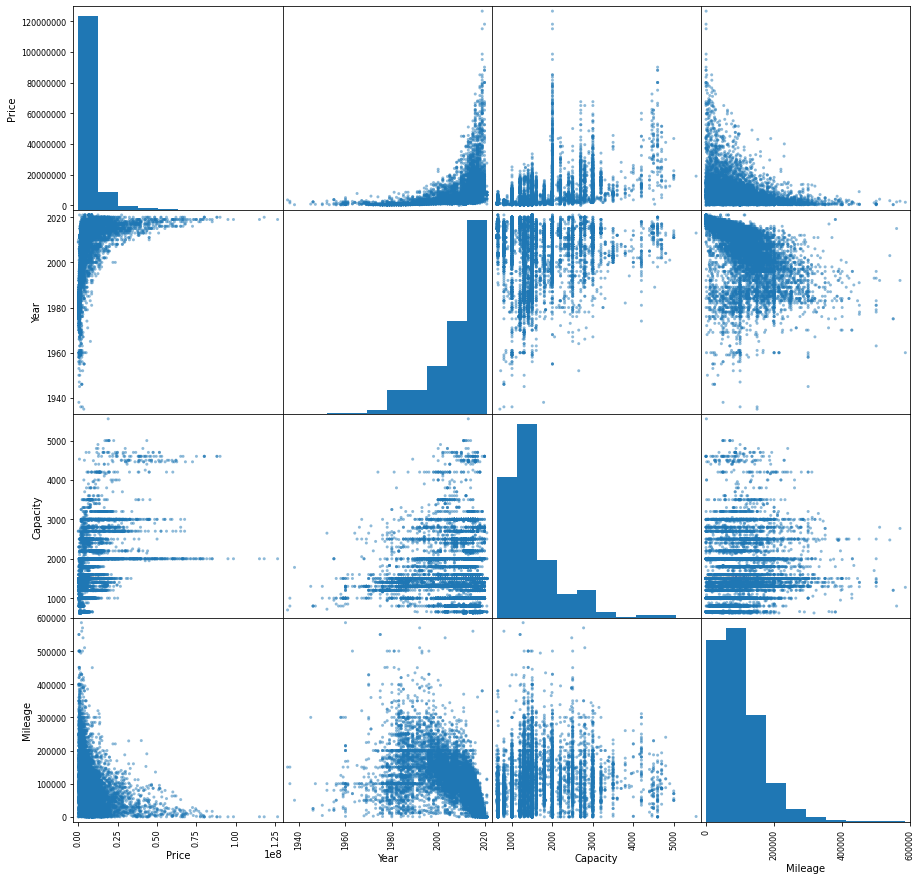

In [26]:
m = scatter_matrix(df_copy, figsize=(15, 15)) #lets explore some of the numeric data

From these graphs there are some clear correlations with price: Year and Mileage 

Lets examine some of the strong correlations 

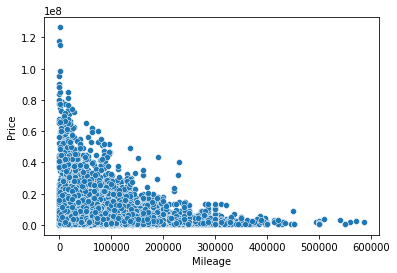

In [27]:
plot = scatterplot(x="Mileage",y="Price",data=df_copy) 

In [28]:
df_copy.corr()

,Price,Year,Capacity,Mileage
Price,1.000000,0.363375,0.492213,-0.295433
Year,0.363375,1.000000,-0.083738,-0.562400
Capacity,0.492213,-0.083738,1.000000,0.217806
Mileage,-0.295433,-0.562400,0.217806,1.000000


### Feature Engineering

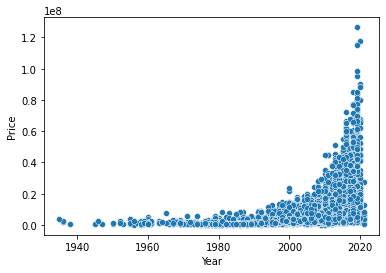

In [29]:
plot = scatterplot(x="Year",y="Price",data=df_copy) 

In [30]:
df_copy['D'] = (1/(((2021-df['Year'])**.5)))   
#this feature essentially calculates a value based off how old the car is, the .5 is the rate of how the price decreases
#as the rate of decay gets bigger (.5), the price gets lower. I chose .5 as the corresponding graph is the closest to a linear graph

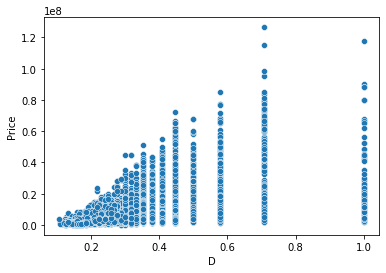

In [31]:
plot = scatterplot(x="D",y="Price",data=df_copy) 

When exploring the correlations, I noticed engine capacity had a strong positive correlation on the price while Mileage had a negative correlation. I also noticed that mileage had an exponentially negative correlation on price. I thus decided to combine the two into the formula below

In [32]:
df_copy['CM'] = (df_copy['Capacity'])-(df['Mileage']**0.5)

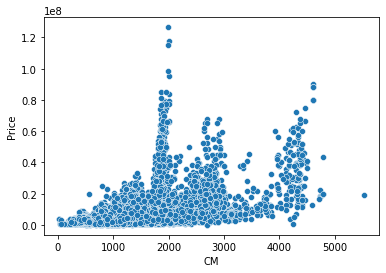

In [33]:
plot = scatterplot(x="CM",y="Price",data=df_copy) 

In [34]:
df_copy.corr()

,Price,Year,Capacity,Mileage,D,CM
Price,1.000000,0.363375,0.492213,-0.295433,0.452674,0.558958
Year,0.363375,1.000000,-0.083738,-0.562400,0.775572,0.003100
Capacity,0.492213,-0.083738,1.000000,0.217806,-0.155475,0.987587
Mileage,-0.295433,-0.562400,0.217806,1.000000,-0.645415,0.068040
D,0.452674,0.775572,-0.155475,-0.645415,1.000000,-0.044081
CM,0.558958,0.003100,0.987587,0.068040,-0.044081,1.000000


In [35]:
# FEATURE WE WANT TO INSERT GOES HERE
class InsertDepr(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["D"] = (1/(((2021-X['Year'])**.5))) 
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

In [36]:
# FEATURE WE WANT TO INSERT GOES HERE
class InsertCM(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X['CM'] = (X['Capacity'])-(X['Mileage']**0.5)
            
            # If the new feature is intended to replace the existing ones, 
            # you could drop the existing ones here
    
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X

### Model Selection

In [37]:
# Extract the features but leave as a DataFrame
dev_X = dev_df[features]
# Target values, converted to a 1D numpy array
dev_y = dev_df["Price"].values


The 'TransformerFromHyperP' ckass allows us to use Transformers as hyperparameters, for this example we try out different types of scalers

In [38]:
class TransformerFromHyperP(BaseEstimator, TransformerMixin):

    def __init__(self, transformer=None):
        self.transformer = transformer
        
    def fit(self, X, y=None):
        if self.transformer:
            self.transformer.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        if self.transformer:
            return self.transformer.transform(X)
        else:
            return X

In [39]:
# Create the preprocessor
preprocessor = ColumnTransformer([
        ("num", Pipeline([("D", InsertDepr()), #This is where our derived feature is inserted
                          ("CM", InsertCM()),
                      ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", TransformerFromHyperP())]), 
            numeric_features),
        ("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")), 
                          ("binarizer", OneHotEncoder(handle_unknown="ignore"))]), 
                nominal_features)],
        remainder="passthrough")

#This preprocessor will replace any missing nominal feature values with the most frequent values
#For numeric data, missing values are replaced with the mean value and the data is scaled so that it is suitable for KNN.

In [40]:
# Create a pipeline that combines the preprocessor with kNN
knn = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", KNeighborsRegressor())])

# Create a dictionary of hyperparameters for kNN
knn_param_grid = {"predictor__n_neighbors": [1, 2, 3, 4, 5],
                  "preprocessor__num__D__insert": [True, False],
                  "preprocessor__num__CM__insert": [True, False],
                  "preprocessor__num__scaler__transformer": [StandardScaler(), MinMaxScaler(), RobustScaler()]
                 }

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(knn, knn_param_grid, scoring="neg_mean_absolute_error", cv=ss)

# Run grid search by calling fit
knn_gs.fit(dev_X,dev_y)

# Let's see how well we did
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 2,
  'preprocessor__num__CM__insert': False,
  'preprocessor__num__D__insert': True,
  'preprocessor__num__scaler__transformer': StandardScaler()},
 -957764.0522614451)

In [41]:
# Create a pipeline that combines the preprocessor with ridge regression
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("predictor", Ridge())])

# Create a dictionary of hyperparameters for ridge regression
ridge_param_grid = {"preprocessor__num__D__insert": [True, False],
                    "preprocessor__num__CM__insert": [True, False],
                    "predictor__alpha": [1e-2,0.0,1.0,5.0, 10.0],
                    "preprocessor__num__scaler__transformer": [StandardScaler(), MinMaxScaler(), RobustScaler()]
                   }

# Create the grid search object which will find the best hyperparameter values based on validation error
ridge_gs = GridSearchCV(ridge, ridge_param_grid, scoring="neg_mean_absolute_error")

# Run grid search by calling fit
ridge_gs.fit(dev_X, dev_y)

# Let's see how well we did
ridge_gs.best_params_, ridge_gs.best_score_

({'predictor__alpha': 1.0,
  'preprocessor__num__CM__insert': False,
  'preprocessor__num__D__insert': True,
  'preprocessor__num__scaler__transformer': MinMaxScaler()},
 -1658357.011019872)

Time to see if we are overfitting or underfitting

In [42]:
knn.set_params(**knn_gs.best_params_) 
scores = cross_validate(knn, dev_X, dev_y, cv=ss, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  504483.8901452473
Validation error:  957764.0522614451


When I ran this the first time, I was highly overfitting. To remidy this I removed some of the features and re ran.

In [43]:
ridge.set_params(**ridge_gs.best_params_) 
scores = cross_validate(ridge, dev_X, dev_y, cv=ss, 
                        scoring="neg_mean_absolute_error", return_train_score=True)
print("Training error: ", np.mean(np.abs(scores["train_score"])))
print("Validation error: ", np.mean(np.abs(scores["test_score"])))

Training error:  1560575.062718279
Validation error:  1756231.6946456425


### Evaluate on the test set

I only evaluated on the test set after I had tweeked and tuned my desired model

In [44]:
# Extract the features from val+train set dataframe
dev_X = dev_df[features]
# Target values from val+train set (dataframe as it was before train/val splitting)
dev_y = dev_df["Price"].values

In [45]:

# Now we re-train on train+validation and test on the test set 
knn.set_params(**knn_gs.best_params_) 
knn.fit(dev_X, dev_y)
mean_absolute_error(test_y, knn.predict(test_X))

993286.6736972705

##### This notebook took aprox. 2 mins 30 secs to run on my laptop when restricted to 1 core